# WOA7015 Alternative Assessment (Additonal Work)

__Group: Learning Machine__


Sub Module

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms, models
from torch import nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
class EfficientMultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        # Use a single projection for QKV to reduce computation
        self.qkv_proj = nn.Linear(embed_dim, 3 * embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B, L, C = x.shape

        # Efficient QKV projection
        qkv = self.qkv_proj(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: t.view(B, L, self.num_heads, self.head_dim).transpose(1, 2), qkv)

        # Use einsum for more efficient attention computation
        attn_weights = torch.einsum('bhqd,bhkd->bhqk', q, k) * self.scale

        if mask is not None:
            attn_weights = attn_weights.masked_fill(mask == 0, float('-inf'))

        attn_probs = F.softmax(attn_weights, dim=-1)
        attn_probs = self.dropout(attn_probs)

        context = torch.einsum('bhqk,bhkd->bhqd', attn_probs, v)
        context = context.transpose(1, 2).contiguous().view(B, L, C)

        return self.out_proj(context)

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.05):
        super().__init__()
        self.attention = EfficientMultiHeadAttention(embed_dim, num_heads, dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            #nn.Dropout(dropout),
        )

    def forward(self, x):
        x = x + self.attention(x)
        x = x + self.mlp(x)
        return x

class RotaryPositionalEmbedding(nn.Module):
    def __init__(self, dim, base=10000):
        super().__init__()
        inv_freq = 1. / (base ** (torch.arange(0., dim, 2.) / dim))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, x, seq_dim=1):
        t = torch.arange(x.shape[seq_dim], device=x.device).type_as(self.inv_freq)
        sinusoid_inp = torch.einsum("i,j->ij", t, self.inv_freq)
        emb = torch.cat((sinusoid_inp.sin(), sinusoid_inp.cos()), dim=-1)
        return emb[None, :, :]

class HybridFPNTransformer(nn.Module):
    def __init__(self, num_classes, image_size=224, patch_size=16,
                 embed_dim=128, num_heads=8, transformer_depth=4):
        super().__init__()

        # Stem network remains the same - processes raw images
        self.stem = nn.Sequential(
            nn.Conv2d(3, embed_dim*2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(embed_dim*2, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(inplace=True)
        )

        # Patch embedding remains the same
        self.patch_embed = nn.Conv2d(
            embed_dim, embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        # Rotary positional embeddings for spatial awareness
        self.rotary_emb = RotaryPositionalEmbedding(embed_dim)

        # Transformer blocks remain unchanged
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, embed_dim)
            for _ in range(transformer_depth)
        ])

        # Simplified classification head - directly from transformer output
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(embed_dim, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # Initial feature extraction
        x = self.stem(x)
        x_patches = self.patch_embed(x)

        # Reshape for transformer processing
        B, C, H, W = x_patches.shape
        x_patches = x_patches.flatten(2).transpose(1, 2)

        # Add positional information
        rotary_pos_emb = self.rotary_emb(x_patches)
        x_patches = x_patches + rotary_pos_emb

        # Process through transformer blocks
        for transformer_block in self.transformer_blocks:
            x_patches = transformer_block(x_patches)

        # Reshape back to 2D and classify
        x_transformed = x_patches.transpose(1, 2).view(B, -1, H, W)
        return self.classifier(x_transformed)

## XAI Implementation (Grad-CAM Visualization)

In [ ]:
# Grad-CAM class definition
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        layer_to_hook = dict(self.model.named_modules()).get(self.target_layer)
        if layer_to_hook is None:
            raise KeyError(f"Layer '{self.target_layer}' not found in the model.")

        # Hook the gradients and activations
        layer_to_hook.register_forward_hook(self.save_activations)
        layer_to_hook.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].clone()

    def __call__(self, x, class_idx=None):
        self.model.eval()
        output = self.model(x)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        self.model.zero_grad()
        target = output[:, class_idx]
        target.backward(retain_graph=True)

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam.squeeze().detach().cpu().numpy()
        cam = cv2.resize(cam, (x.size(-1), x.size(-2)))

        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)  # Normalize
        return cam

In [ ]:
# Function to load the model
def load_model(model_path, model_class, num_classes=4):
    model = model_class()
    if isinstance(model, torchvision.models.AlexNet):
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif isinstance(model, torchvision.models.ResNet):
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif isinstance(model, torchvision.models.VGG):
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif isinstance(model, HybridFPNTransformer):
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)

    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint, strict=False)
    model.eval()
    return model

In [ ]:
# Custom transformations for MRI images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Paths to models
base_dir = '/content/drive/MyDrive/WOA7015_ML_GroupAssignment/Alternative_Assignment'
models_dir = os.path.join(base_dir, 'Final_project/models')

model_paths = {
    'AlexNet': os.path.join(models_dir, 'AlexNet_best.pth'),
    'Custom': os.path.join(models_dir, 'Transformer_49_f1_0.9847.pth'),
    'ResNet18': os.path.join(models_dir, 'ResNet18_best.pth'),
    'VGG16': os.path.join(models_dir, 'VGG16_best.pth')
}

# Initialize models
model_classes = {
    'AlexNet': lambda: models.alexnet(),
    'Custom': lambda: HybridFPNTransformer(num_classes = 4),
    'ResNet18': lambda: models.resnet18(),
    'VGG16': lambda: models.vgg16()
}

# Target layers for each model
target_layers = {
    'AlexNet': 'features.12',
    'Custom': 'patch_embed',
    'ResNet18': 'layer4.1.conv2',
    'VGG16': 'features.29'
}

In [ ]:
# View Models Architecture
for model_name, model_fn in model_classes.items():
    print(f"Modules in {model_name}:")
    model = model_fn()
    for name, module in model.named_modules():
        print(f" {name}: {module}")
    print("\n")

Modules in AlexNet:
 : AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_feat

In [ ]:
# Load models and initialize Grad-CAM
models_gradcam = {}
for model_name, model_path in model_paths.items():
    if model_path.endswith('.pth'):
        model = load_model(model_path, model_classes[model_name])
        grad_cam = GradCAM(model, target_layers[model_name])
        models_gradcam[model_name] = grad_cam

# Randomly select an MRI image from each folder under Testing
testing_folder = os.path.join(base_dir, 'tumor_dataset/Testing')
labels = os.listdir(testing_folder)
images = []
for label in labels:
    image_files = os.listdir(os.path.join(testing_folder, label))
    selected_image = random.choice(image_files)
    selected_image_path = os.path.join(testing_folder, label, selected_image)
    images.append((label, selected_image_path))


<ipython-input-87-c6c3bf589274>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=torch.device('cpu'))


<ipython-input-91-674a423caf1b>:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


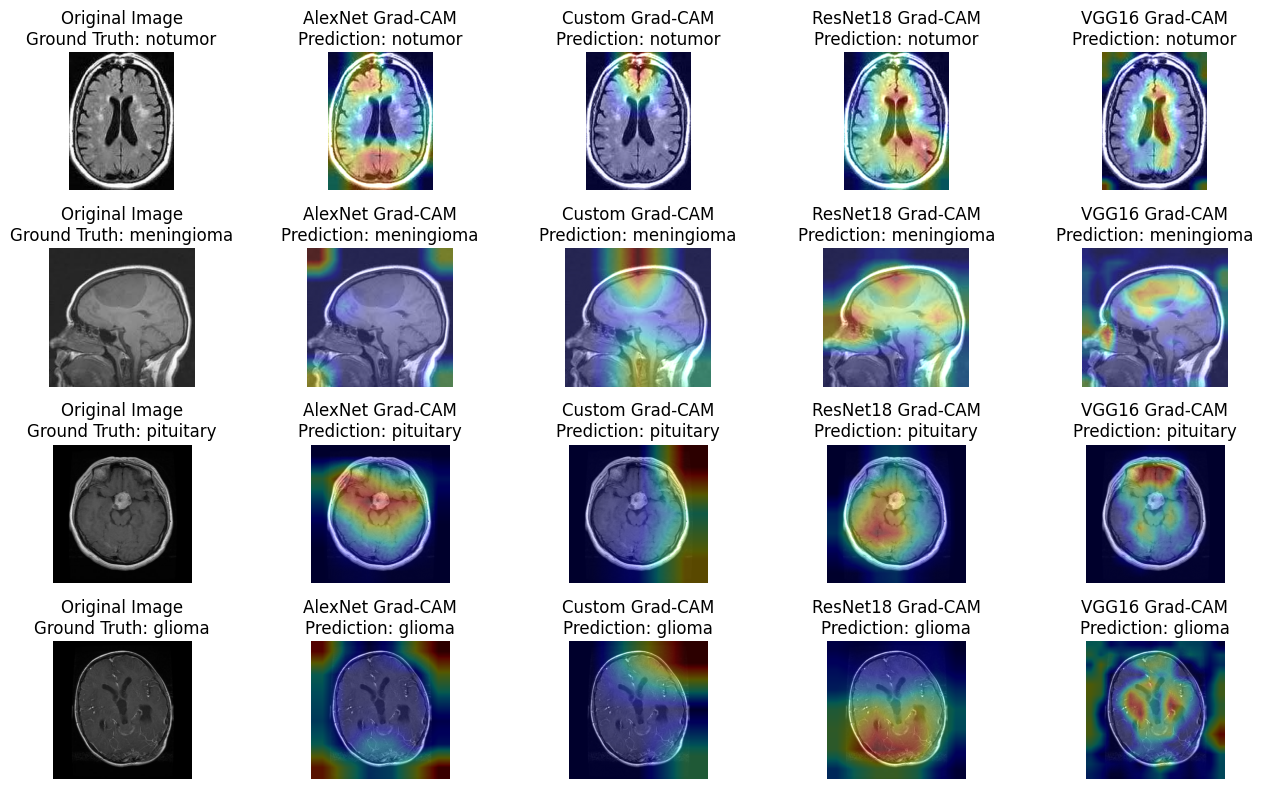

In [ ]:
label_mapping = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}

# Apply Grad-CAM and plot results for each image
plt.figure(figsize=(15, 8))

for row, (label, image_path) in enumerate(images):
    # Preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_size = (image.shape[1], image.shape[0])

    input_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])(image).unsqueeze(0)

    plt.subplot(4, 5, row * 5 + 1)
    plt.imshow(image)
    plt.title(f"Original Image\nGround Truth: {label}", fontsize=12)
    plt.axis('off')

    for col, (model_name, grad_cam) in enumerate(models_gradcam.items(), start=2):

        # Generate Grad-CAM heatmap
        heatmap = grad_cam(input_tensor)
        with torch.no_grad():
            prediction = model(input_tensor).argmax(dim=1).item()
        label_name = label_mapping[prediction]

        # Normalize heatmap to [0, 255]
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
        heatmap = np.uint8(255 * heatmap)

        # Use jet colormap to colorize the heatmap
        jet = plt.cm.get_cmap("jet")
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]
        jet_heatmap_img = Image.fromarray((jet_heatmap * 255).astype(np.uint8))
        jet_heatmap_img = jet_heatmap_img.resize((image.shape[1], image.shape[0]))
        jet_heatmap_array = np.array(jet_heatmap_img)

        # Superimpose the heatmap on the original image
        alpha = 0.35
        superimposed_img = jet_heatmap_array * alpha + image
        superimposed_img_normalized = np.clip(superimposed_img / 255.0, 0, 1)

        plt.subplot(4, 5, row * 5 + col)
        plt.imshow(superimposed_img_normalized)
        plt.title(f"{model_name} Grad-CAM\nPrediction: {label_name}", fontsize=12)
        plt.axis('off')
        plt.tight_layout()

## LLM Exploration (Gemini API's experimental models: Gemini 2.0 Flash)
### https://ai.google.dev/gemini-api/docs/models/experimental-models

<br/>__Input:__ Image
<br/>__Output:__ Text

In [ ]:
# Install SDK for Gemini API
!pip install -q -U google-generativeai

In [ ]:
# Pass an original MRI image sample that has no ground truth label to the LLM to simulate a real-world situation.
# LLM is used to analysis and generate a diagnostic interpretation in text format based on the prediction results
# of all models and their Grad-CAM visualization images to assist the radiologist in diagnosis.

# Randomly select an MRI image from Testing folder
testing_folder = os.path.join(base_dir, 'tumor_dataset/Testing')
labels = os.listdir(testing_folder)
selected_label = random.choice(labels)
selected_image_path = random.choice(os.listdir(os.path.join(testing_folder, selected_label)))
selected_image_full_path = os.path.join(testing_folder, selected_label, selected_image_path)

<ipython-input-70-8c508794ae36>:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


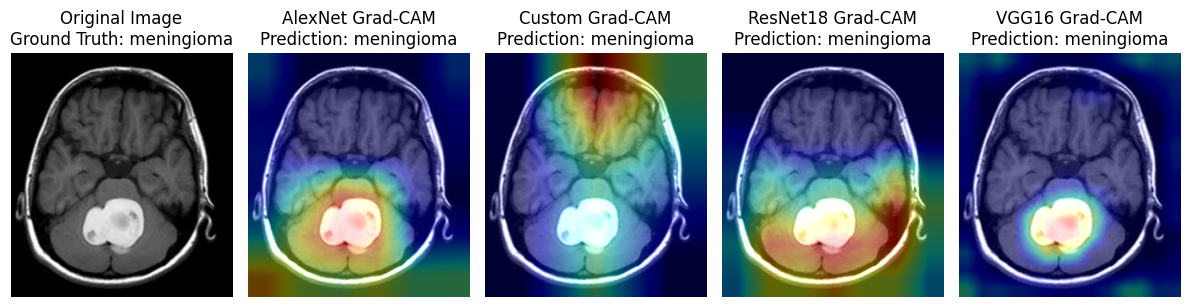

In [ ]:
# Create and save an image that fits the input requirements of Scenario 1

image = cv2.imread(selected_image_full_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
original_size = (image.shape[1], image.shape[0])

input_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])(image).unsqueeze(0)

label_mapping = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}
output_save_path = os.path.join(base_dir, 'tumor_dataset/Imgs/gradcam_visualization_s1.png')
predictions = []

# Apply Grad-CAM and plot results
plt.figure(figsize=(12, 8))
plt.subplot(1, 5, 1)
plt.imshow(image)
plt.title(f"Original Image\nGround Truth: {selected_label}", fontsize=12)
plt.axis('off')

for i, (model_name, grad_cam) in enumerate(models_gradcam.items(), start=2):

   # Generate Grad-CAM heatmap
    heatmap = grad_cam(input_tensor)
    with torch.no_grad():
        prediction = model(input_tensor).argmax(dim=1).item()
    label_name = label_mapping[prediction]

    # Normalize heatmap to [0, 255]
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize the heatmap
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap_img = Image.fromarray((jet_heatmap * 255).astype(np.uint8))
    jet_heatmap_img = jet_heatmap_img.resize((image.shape[1], image.shape[0]))
    jet_heatmap_array = np.array(jet_heatmap_img)

    # Superimpose the heatmap on the original image
    alpha = 0.4
    superimposed_img = jet_heatmap_array * alpha + image
    superimposed_img_normalized = np.clip(superimposed_img / 255.0, 0, 1)

    plt.subplot(1, 5, i)
    plt.imshow(superimposed_img / 255)
    plt.title(f"{model_name} Grad-CAM\nPrediction: {label_name}", fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.savefig(output_save_path, bbox_inches='tight')
plt.show()

<ipython-input-82-dd1a61b5803f>:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


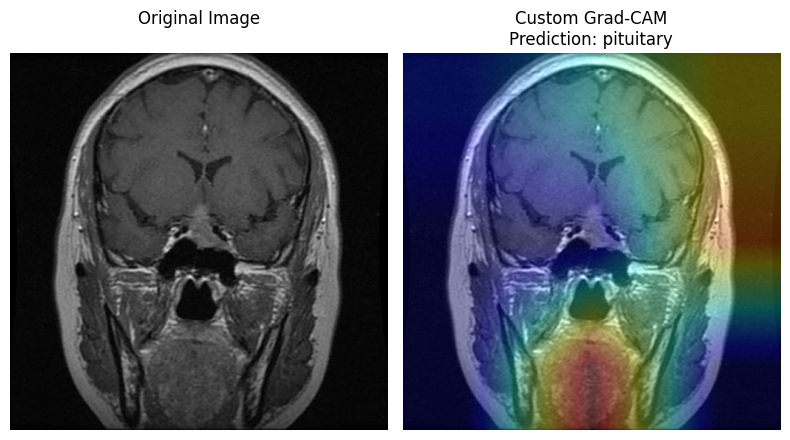

In [ ]:
# Create and save an image that fits the input requirements of Scenario 2
testing_folder = os.path.join(base_dir, 'tumor_dataset/Testing')
labels = os.listdir(testing_folder)
selected_label = random.choice(labels)
selected_image_path = random.choice(os.listdir(os.path.join(testing_folder, selected_label)))
selected_image_full_path = os.path.join(testing_folder, selected_label, selected_image_path)

image = cv2.imread(selected_image_full_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
original_size = (image.shape[1], image.shape[0])

input_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])(image).unsqueeze(0)

label_mapping = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}
output_save_path = os.path.join(base_dir, 'tumor_dataset/Imgs/gradcam_visualization_s2.png')
predictions = []

# Apply Grad-CAM and plot results
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f"Original Image\n", fontsize=12)
plt.axis('off')

for i, (model_name, grad_cam) in enumerate(models_gradcam.items(), start=2):
    if model_name == 'Custom':
        # Generate Grad-CAM heatmap
        heatmap = grad_cam(input_tensor)
        prediction = model(input_tensor).argmax(dim=1).item()
        label_name = label_mapping[prediction]
        predictions.append((model_name, prediction))

        # Normalize heatmap to [0, 255]
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
        heatmap = np.uint8(255 * heatmap)

        # Use jet colormap to colorize the heatmap
        jet = plt.cm.get_cmap("jet")
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]
        jet_heatmap_img = Image.fromarray((jet_heatmap * 255).astype(np.uint8))
        jet_heatmap_img = jet_heatmap_img.resize((image.shape[1], image.shape[0]))
        jet_heatmap_array = np.array(jet_heatmap_img)

        # Superimpose the heatmap on the original image
        alpha = 0.3
        superimposed_img = jet_heatmap_array * alpha + image
        superimposed_img_normalized = np.clip(superimposed_img / 255.0, 0, 1)

        plt.subplot(1, 2, 2)
        plt.imshow(superimposed_img / 255)
        plt.title(f"{model_name} Grad-CAM\nPrediction: {label_name}", fontsize=12)
        plt.axis('off')

plt.tight_layout()
plt.savefig(output_save_path, bbox_inches='tight')
plt.show()

### LLM Testing: Sample 1

Test with a sample to see whether the API works

In [ ]:
import textwrap
from IPython.display import display
from IPython.display import Markdown

def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

In [ ]:
import requests
import PIL.Image
import google.generativeai as genai
# Used to securely store API key
from google.colab import userdata

gemini_api_key = userdata.get('GOOGLE_API_KEY')
MODEL = 'gemini-2.0-flash-exp'
base_dir = '/content/drive/MyDrive/WOA7015_ML_GroupAssignment/Alternative_Assignment'

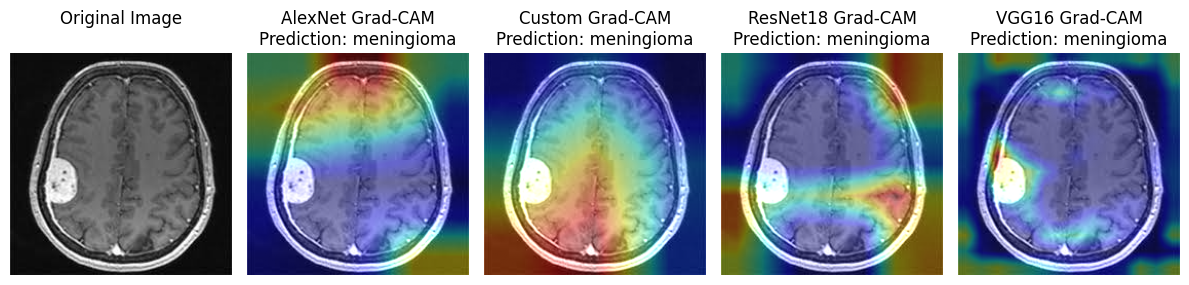

In [ ]:
image_path =  os.path.join(base_dir, 'tumor_dataset/gradcam_visualization_final_1.png')

genai.configure(api_key=gemini_api_key)
genai_model = genai.GenerativeModel(MODEL)

img = PIL.Image.open(image_path)
img

In [ ]:
response = genai_model.generate_content([
    "You are an expert medical assistant."
    "Analyze the provided Grad-CAM visualization showing predictions for brain tumor classification "
    "(classes: glioma, meningioma, notumor, pituitary) from four models: AlexNet, Custom, ResNet18, and VGG16. "
    "The Grad-CAM visualization shows the regions influencing each model's decision, with predictions labeled on top. "
    "Provide a detailed interpretation to assist the radiologist in diagnosing whether the sample indicates a brain tumor, "
    "and if so, specify the type of tumor (glioma, meningioma, pituitary) and interpret the MRI scan."
    "Remove 'Certainly' in your first line of response, directly give the analysis.", img], stream=True)

response.resolve()

to_markdown(response.text)

> All four models (AlexNet, Custom, ResNet18, and VGG16) unanimously predict a meningioma. The original MRI image displays a well-defined, extra-axial mass located in the right parietal region, which is characteristic of a meningioma. The mass appears isointense to the gray matter on the T1-weighted image, with some internal heterogeneity.
> 
> **Grad-CAM Interpretations:**
> 
> *   **AlexNet:** The Grad-CAM visualization for AlexNet shows a wide area of activation, with warmer colors (red/yellow) concentrated over the tumor region and extending somewhat into the surrounding areas. The model seems to be focusing on the tumor mass itself, with some spillover into other areas.
> 
> *   **Custom Model:** This model also shows a strong focus on the tumor, with very defined hot spots overlapping precisely over the lesion's location. This suggests that this model has learned to tightly associate the specific visual characteristics of this tumor with the meningioma class.
> 
> *  **ResNet18:** ResNet18’s activation map is concentrated more towards the base and edges of the tumor mass and extends into the surrounding tissue along the margins and extending down towards the base of the skull.. This might suggest it's paying attention to aspects such as the interface between the tumor and the surrounding brain or skull.
> 
> *   **VGG16:** The VGG16 model’s visualization shows a fairly localized activation, predominantly over the tumor, but has a similar spread and is not as concentrated as the custom network. This suggests the model is also primarily focusing on the tumor but may have slightly less precision compared to custom model.
> 
> **Overall Impression and Diagnosis:**
> 
> The consensus among all four models is consistent and strongly indicative of a meningioma. All of the Grad-CAM heatmaps highlight the tumor region, suggesting the models are indeed focusing on the relevant pathological area. The morphological characteristics visible in the original MRI image (extra-axial location, well-defined borders, round mass) are also highly supportive of a meningioma.
> 
> **Recommendation:**
> 
> The radiologist should interpret this case as a high likelihood of meningioma. Further evaluation, which could include contrast-enhanced MRI sequences for further characterization and a possible biopsy for histological confirmation, should be considered for definitive diagnosis and management planning. The consistent predictions across multiple models and the relevant features in the original MRI scan strongly support the conclusion of a meningioma.

### Scenario 1: Developer-Doctor Collaboration

```
•	Objective: Validate and interpret model predictions during testing.
•	Setting: Developers collaborate with doctors to explain how Grad-CAM visualizations highlight important regions in MRI images. This helps doctors understand the AI’s decision-making process and compare predictions with their clinical expertise.
•	Input: An image containing the original MRI image (with a ground truth label) and Grad-CAM visualizations for all four models (AlexNet, Custom, ResNet18, VGG16), with predictions labelled on top.
•	Expected outcome: The LLM acts as a developer, providing educational support to the doctor on interpreting Grad-CAM visualizations.
```

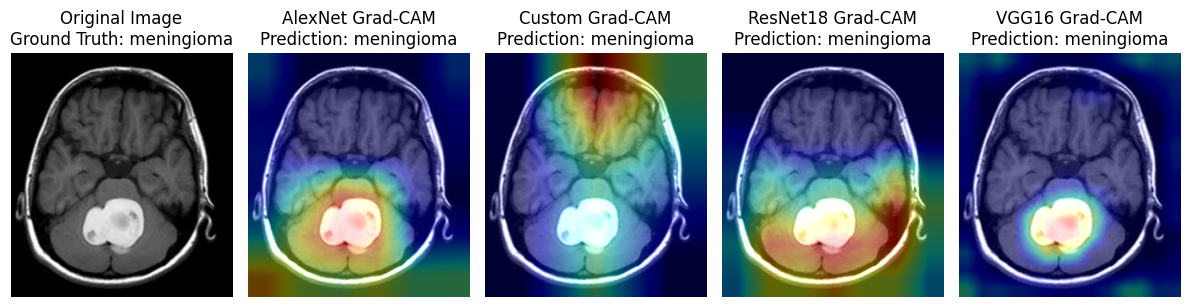

In [ ]:
image_path =  os.path.join(base_dir, 'tumor_dataset/Imgs/gradcam_visualization_s1.png')

genai.configure(api_key=gemini_api_key)
genai_model = genai.GenerativeModel(MODEL)

img = PIL.Image.open(image_path)
img

In [ ]:
response = genai_model.generate_content([
    "You are the data scientist of the developer team for the brain tumours classification project, which includes Explainable AI (XAI) via Grad-CAM."
    "Explain to doctors how Grad-CAM visualizations highlight important regions in MRI images and how these regions influence model decisions."
    "The input is an image containing the original MRI image with a ground truth label (leftmost) and corresponding Grad-CAM visualizations for each model (AlexNet, Custom, ResNet18, and VGG16) with predictions labelled on top. "
    "Provide interpretations for each model’s Grad-CAM visualization, discuss their predictions,"
    "and give an overall diagnosis, specifying whether the models classified the tumours correctly (glioma, meningioma, no tumours, pituitary) for this MRI sample", img], stream=True)

response.resolve()

to_markdown(response.text)

> Okay, let's delve into how Grad-CAM is helping us understand our models' decisions for this MRI image.
> 
> **Understanding Grad-CAM**
> 
> Grad-CAM (Gradient-weighted Class Activation Mapping) is a technique used to make our machine learning models more transparent. Essentially, it highlights the image regions that are most important in influencing the model’s prediction for a given class. The visualizations are overlaid as a heatmap on the original image. The warmer the colors (red, yellow), the higher the activation, and the more influential that region is to the model’s prediction. Conversely, cooler colors (blue) indicate less influence.
> 
> **Analysis of the Provided MRI Image and Grad-CAM Visualizations**
> 
> Here we see an MRI image with a significant tumour at the base of the brain. The ground truth label is “meningioma,” so we expect the models to classify this image as such.  Let's break down the Grad-CAM visualizations from each model:
> 
> **1. AlexNet Grad-CAM:**
> 
> *   **Prediction:** Meningioma
> *   **Visualization:** The heatmap focuses very strongly on the meningioma. The most intense red areas are directly over the tumour itself, and it also covers the area surrounding the tumour which is also very relevant.
> *   **Interpretation:** AlexNet correctly identifies the tumour and indicates that the tumour's features are the primary reasons for its classification. The focus is reasonably precise and localized.
> 
> **2. Custom Grad-CAM:**
> 
> *   **Prediction:** Meningioma
> *   **Visualization:** This heatmap is broader, it shows activation over the whole tumour, however it is not as precise and it is also activated in the top of the brain which is less relevant for this diagnosis.
> *   **Interpretation:** While the model correctly predicts meningioma, its area of influence is slightly less specific. Still, the core areas of activation align well with the tumour's location.
> 
> **3. ResNet18 Grad-CAM:**
> 
> *   **Prediction:** Meningioma
> *   **Visualization:** Similar to AlexNet, the heatmap concentrates strongly on the tumor area, with the strongest activation again appearing right over the mass.
> *   **Interpretation:** ResNet18 has a very precise focus on the tumour area, demonstrating a clear and correct understanding of where the relevant diagnostic information lies.
> 
> **4. VGG16 Grad-CAM:**
> 
> *   **Prediction:** Meningioma
> *   **Visualization:** This heatmap is quite similar to the one generated by ResNet18, with strong activation concentrated on the meningioma and surrounding area.
> *   **Interpretation:** VGG16 also shows a clear emphasis on the tumor's characteristics, which confirms its role in the classification.
> 
> **Overall Diagnosis**
> 
> All four models (AlexNet, Custom, ResNet18, and VGG16) correctly classified the image as having a **meningioma**. 
> 
> In summary, the Grad-CAM visualizations provide insights into how these models make decisions and demonstrates that all four models have understood which features are important for classification. All models focus on the tumour region.
> 
> **How this Helps Doctors**
> 
> 1.  **Validation of AI Predictions:** The Grad-CAM visualizations allow you to verify that the model is focusing on the relevant areas. If the heatmap is misplaced or focused on irrelevant areas, it can raise questions about the model's reliability.
> 2.  **Understanding the Basis for Decisions:**  These visualizations show *why* a model makes a particular classification. It's not just a "black box" spitting out a diagnosis; we can see which regions of the image played a crucial role. This helps clinicians assess the plausibility of the model's reasoning.
> 3.  **Identifying Potential Errors:** If a model misclassifies an image and the Grad-CAM reveals the wrong areas of the image being the focus, then you can assess the model’s limitations, and if necessary we can take a look into the training and optimize the model.
> 4.  **Confidence Building:** Ultimately, transparency through XAI helps in building trust and acceptance of these AI systems in clinical practice. When doctors understand the rationale behind a machine learning prediction, it makes it easier to incorporate these tools into their workflows.
> 
> Let me know if you have any further questions!


### Scenario 2: Doctor-Patient Interaction

```
•	Objective: Explain the diagnostic result to a patient using Grad-CAM visualizations and LLM-generated interpretations.
•	Setting: Doctors use the AI model to explain the diagnosis transparently, building trust by showing how decisions are made and results are obtained.
•	Input: An image containing the original MRI image (without a ground truth label) and the Grad-CAM visualization for the Custom Model with its prediction labelled on top.
•	Expected outcome: The LLM acts as the doctor, generating a patient-friendly explanation of the diagnostic result which emphasizes the reasoning behind the model’s prediction and the highlighted regions from Grad-CAM.
```

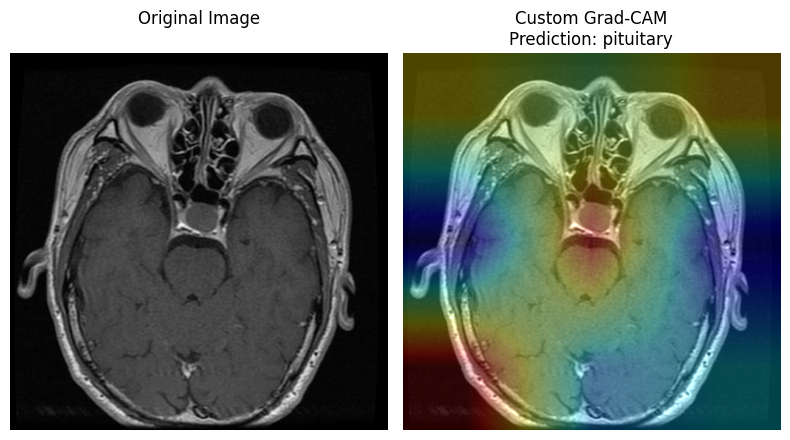

In [ ]:
image_path =  os.path.join(base_dir, 'tumor_dataset/Imgs/gradcam_visualization_s2.png')

genai.configure(api_key=gemini_api_key)
genai_model = genai.GenerativeModel(MODEL)

img = PIL.Image.open(image_path)
img

In [ ]:
response = genai_model.generate_content([
    "You are a doctor."
    "Explain the diagnosis result to the patient using the developed AI model."
    "Analyse the Grad-CAM visualization for brain tumour classification (glioma, meningioma, no tumours, pituitary) from the Custom Model."
    "Highlight the regions influencing the model’s decision, with predictions labelled on top. "
    "Provide a detailed interpretation to assist in diagnosing whether the sample indicates a brain tumour, specify the tumour type if present,"
    "and explain the diagnosis to the patient by interpreting the Grad-CAM", img], stream=True)

response.resolve()

to_markdown(response.text)

> Okay, let's go over your MRI scan results.
> 
> **What we see here:**
> 
> On the left is your original MRI image. On the right is what we call a Grad-CAM visualization, where colors are overlaid on top of your MRI image. The colors are meant to highlight which areas of the scan our AI model paid the most attention to when making its diagnosis. The areas with warmer colors, like reds and oranges, indicate regions the model deemed most relevant for its prediction.
> 
> **AI Prediction:**
> 
> The model's prediction here is "pituitary," which means that the AI model believes there may be a tumor on your pituitary gland. 
> 
> **Grad-CAM Analysis**
> 
> Looking at the Grad-CAM image, you can see that the red and orange areas are concentrated around the area of the pituitary gland, which is located at the base of your brain, behind your eyes. This concentration of color suggests that the AI model is focusing on this specific area when it predicted pituitary tumor. The other areas of the scan have a more subtle coloration.
> 
> **Interpretation:**
> 
> Based on this analysis, there is a high probability of a pituitary tumor. This is because the model has concentrated on this region with high intensity, indicating that the model has found the specific pattern in this region it relates to a pituitary tumor.  
> 
> **What Does This Mean for You?**
> 
> While the AI model is a very helpful tool for initial analysis, it's important to remember that it is not a replacement for a medical expert. 
> 
> Here is the summary of our interpretation: The AI suggests you may have a pituitary tumor. It is very important that we confirm this through further testing, like:
>     - Hormone level testing 
>     - Repeat MRI with higher resolution images to see the size
>     - Possibly visual field testing
> 
> **Next Steps:**
> 
> Based on this analysis, I would recommend that you:
> 1. Schedule a follow-up appointment for further evaluation. We will repeat the MRI and also do hormone level testing.
> 2. Be prepared to discuss your medical history and any symptoms you might be having.
> 3. Be prepared for a visual field test as pituitary tumors can compress on the optic nerve, which causes vision problems.
> 
> I am here to answer any questions you may have, and please understand that further testing is needed before we can create a treatment plan. I am here to help you through this process.